In [1]:
import torch 
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

from model.model import SentenceEncoder, SentenceDecoder, ImageEncoder, cnnTransforms
from dataset import VisDialDataset
from utils.token import Lang
jsonFile = "/home/ball/dataset/mscoco/visdialog/visdial_1.0_val.json"
cocoDir = "/home/ball/dataset/mscoco/"
langFile = "dataset/lang.pkl"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
lang = Lang.load(langFile)
dataset = VisDialDataset(dialFile = jsonFile,
                         cocoDir = cocoDir, 
                         sentTransform = torch.LongTensor,
#                          imgTransform = cnnTransforms,
                         convertSentence = lang.sentenceToVector)

Load lang model: dataset/lang.pkl. Word size: 43974


Preparing image paths with image_ids: 133351it [00:00, 374781.06it/s]


In [3]:
def collate_fn(batch):
    images = []
    captions = []
    for row in batch:
        images.append(row["image"])
        captions.append(row["caption"])
    images = torch.stack(images)
    return {
        "images": images,
        "captions": captions
    }

In [11]:
import os
import matplotlib.pyplot as plt
modelFile= "outputs/pretrain"
number = 29
sentDecoder = torch.load(os.path.join(modelFile, "sentence{}.pkl".format(number))).to(DEVICE).eval()
imgcnn = torch.load(os.path.join(modelFile, "image{}.pkl".format(number))).to(DEVICE).eval()

In [9]:
DEVICE

device(type='cuda')

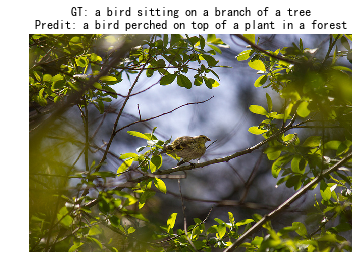

In [14]:
row = dataset[35]
plt.axis('off')
plt.imshow(row["image"])
plt.title("GT: {}\nPredit: {}".format(
    lang.vectorToSentence(row["caption"].numpy()),
    predit(row["image"]))
)
plt.show()

In [6]:
def predit(image):    
    image_t = cnnTransforms(image).unsqueeze(0).to(DEVICE)
    imgout = imgcnn(image_t)
    
    inputs = torch.LongTensor([[lang["<SOS>"]]]).to(DEVICE)
    hidden = None
    ans = []
    for i in range(20):
        outputs, hidden = sentDecoder(inputs, imgout, hidden)
        prob, outputs = outputs.topk(1)
        if(outputs.item() == lang["<EOS>"]):
            break
        ans.append(outputs.item())

        inputs = outputs.squeeze(1).detach()
    return lang.vectorToSentence(ans)

In [8]:
in_seq = []
out_seq = []
for cap in data["captions"]:
    in_seq.append(torch.cat([torch.LongTensor([lang["<SOS>"]]), cap]).to(DEVICE))
    out_seq.append(torch.cat([cap, torch.LongTensor([lang["<EOS>"]])]).to(DEVICE))
out_seq = pad_sequence(out_seq, batch_first=True)
images = data["images"].to(DEVICE)

In [9]:
imgout = imgcnn(images)
sentout, senthidden = sentDecoder(in_seq, imgout)

In [15]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam([[imgcnn.parameters()]], lr=1e-4)

TypeError: optimizer can only optimize Tensors, but one of the params is list

In [28]:
logout = F.log_softmax(sentout, dim=1).topk(1)[1]
logout.squeeze(2) == out_seq

tensor([[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]],
       device='cuda:0', dtype=torch.uint8)

In [32]:
lang.vectorToSentence(logout.squeeze(2)[4].cpu().numpy())

'a black and white photo of young people holding an open umbrella <EOS> macbooks prosecuted" garden,'

In [62]:
logout.squeeze(2)[1]

tensor([    4,   645,  1511,   262,    79,   525,    56,    24,  1879,     2,
        13351, 28743, 31624, 16415, 11541, 31502], device='cuda:0')